### Imports et initialisations

In [1]:
from clustertools import *

In [2]:
from importlib import reload
import clustertools
reload(clustertools)
from clustertools import *

In [3]:
clusters_dir = "clusters/Africain_Min_clusters/"

### Charger les clusters en mémoire

In [7]:
cc, rc, tdc = load_clusters(clusters_dir + "som_25/")

Reconstituer le jeu de données entier, obtenir la liste des mots ignorés, les mots les plus fréquents par clusters et le pourcentage de messages contenant un mot haineux par cluster.

In [8]:
dataset = []
for i, cluster in enumerate(cc):
    dataset += cluster
wlists = [create_sorted_wlist(cluster) for cluster in cc]

ignored = [tup[0] for tup in create_sorted_wlist(dataset)[:n_most_freq_ignored]]

mfw = most_freq_words(n_clust_info, wlists, ignored)
hkw = search_hate_words(rc, kw_file)

clust_n_msg = [(i, len(clust)) for i, clust in enumerate(cc)]

### Analyse, affichage des informations et visualisation

### Chargement du modèle de validation

In [9]:
import torch 
from transformers import CamembertForSequenceClassification, CamembertTokenizer

tokenizer = CamembertTokenizer.from_pretrained("models/tweetbert", do_lowercase=False)
classifier = CamembertForSequenceClassification.from_pretrained("models/tweetbert_FT_rand_balanced")

In [10]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
r = classifier.to(device)

In [11]:
def predict(sample):
    pred = []
    for n in range(0, len(sample), 10):
        phrases = sample[n:n+10]
        enc = tokenizer(phrases, padding=True, truncation=True, max_length=512, return_tensors='pt')
        enc.to('cuda:0')
        with torch.no_grad():
            outp = classifier(**enc)
        p = torch.nn.functional.softmax(outp.logits, dim=1)
        labels = torch.argmax(p, dim=1)
        pred.append(labels)
    return torch.cat(pred)

In [12]:
%%time 
hate_pred = []
for clust in rc:
    hate_pred.append(predict(clust))

CPU times: user 47.4 s, sys: 20 ms, total: 47.4 s
Wall time: 48.3 s


In [13]:
hper = []
for i, p in enumerate(hate_pred):
    bc = torch.bincount(p, minlength=2)
    perc = (bc[1] / (bc[0]+bc[1])).item() * 100
    hper.append(perc)

#### Affichage des informations

In [14]:
print_clusters_info(clust_n_msg, mfw, hkw, hper)

Cluster 0 : 99 messages
18 messages contiennent un mot-clé haineux (soit 18.18%)
21.21% de messages sont détectés comme haineux par le modèle
Les 20 mots les plus fréquents : métèque album renaud nouvel métèque, son via sort ses chanson reprises 70 ... française disque j’ai voté macron me pinçant 


Cluster 1 : 17 messages
8 messages contiennent un mot-clé haineux (soit 47.06%)
76.47% de messages sont détectés comme haineux par le modèle
Les 20 mots les plus fréquents : ton mon babouin bamboula son bientôt twitter rachèté, ouaii! bougnoulenegronazibamboulahitlermemphisboomernakedsexanalincestviolsimpincelchattebaisernegreenculer visage dirait comment va demi négre? commentaire connard de? envoie 


Cluster 2 : 249 messages
168 messages contiennent un mot-clé haineux (soit 67.47%)
57.83% de messages sont détectés comme haineux par le modèle
Les 20 mots les plus fréquents : maison narcisse conrad joseph service arabe roman ... rebaptisé mot encore autre via blanc offenser toujours bien p

#### Visualisation

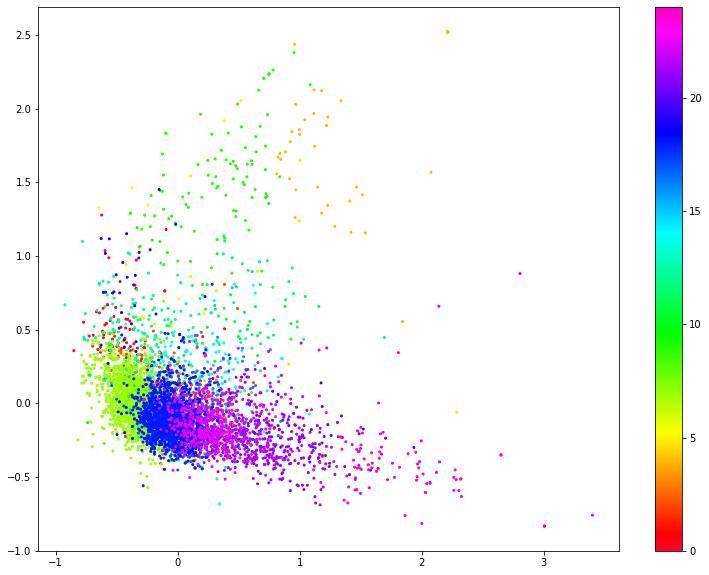

In [16]:
plot_clusters(tdc)

### Ou plus rapidement :

Cluster 0 : 99 messages
18 messages contiennent un mot-clé haineux (soit 18.18%)
Les 20 mots les plus fréquents : métèque album renaud nouvel métèque, son via sort ses chanson reprises 70 ... française disque j’ai voté macron me pinçant 


Cluster 1 : 17 messages
8 messages contiennent un mot-clé haineux (soit 47.06%)
Les 20 mots les plus fréquents : ton mon babouin bamboula son bientôt twitter rachèté, ouaii! bougnoulenegronazibamboulahitlermemphisboomernakedsexanalincestviolsimpincelchattebaisernegreenculer visage dirait comment va demi négre? commentaire connard de? envoie 


Cluster 2 : 249 messages
168 messages contiennent un mot-clé haineux (soit 67.47%)
Les 20 mots les plus fréquents : maison narcisse conrad joseph service arabe roman ... rebaptisé mot encore autre via blanc offenser toujours bien petit raison enfants 


Cluster 3 : 116 messages
59 messages contiennent un mot-clé haineux (soit 50.86%)
Les 20 mots les plus fréquents : y dit bon son ... dire babouin avait banania 

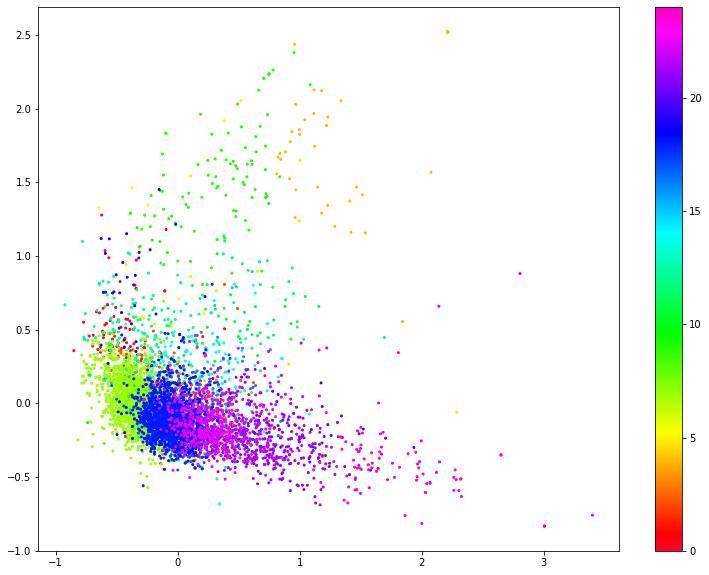

In [17]:
parse_clusters(cc, rc, tdc)